In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy.sparse import vstack

import os
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.model_selection import GroupShuffleSplit
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

Import data, get helper files:

In [2]:
path = "C:/Users/NORA/hlca_core.h5ad"
adata = anndata.read_h5ad(path, backed = 'r')

In [3]:
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
individual_labels = adata.obs['donor_id']

In [4]:
with open('../2. Main classification experiment/helper_pickle_files/color_mappings.pickle', 'rb') as file:
    color_mappings = pickle.load(file)

with open('../2. Main classification experiment/helper_pickle_files/cell_names.pickle', 'rb') as file:
    cell_names = pickle.load(file)

## Generate classification templates where one cell type is fixed:


Here, we generate scripts as for the naive split setting experiment, except with a modified train-predict function that fixsdthel countsof one cell type  across female proportions in the training set.The cell type we want to fix is passed as an argument. The templates and generation functions are similar to the main donor-based classification experiment, except we only care about one random seed, two annotation levels (finest for Monocyte-derived Mph and ann_level_4 for Suprabasal) and one classifier (KNN).t

In [5]:
# folder names
root_folder = 'donorbased_fix_classif'
anns = [ 'ann_4', 'ann_finest']
result_folders = ['cms', 'norm_cms']

for ann in anns:
    for result_folder in result_folders:
        path = os.path.join(root_folder, ann, result_folder)
        os.makedirs(path, exist_ok = True)

In [6]:
def get_label_assignment(ann_value):
    # for 'None' entries, go back and get coarser cell type label
    if ann_value == "adata.obs.ann_level_4":
        return (
            "cell_type_labels = adata.obs['ann_level_4'].astype(str)\n"
            "cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_3'].astype(str))\n"
            "cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_2'].astype(str))"
        )
    else:
        # no need to handle 'None's for ann_finest
        return f"cell_type_labels = {ann_value}"

In [7]:
def generate_knn_script(prop_value, ann_value, class_name):
    label_assignment = get_label_assignment(ann_value)
    return f"""# KNN classification script

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
import seaborn as sns

print('successfully imported packages!', flush=True)

path = '/winhome/noraghenciules/hlca_data.h5ad'
adata = anndata.read_h5ad(path)

print('successfully read file!', flush=True)

embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
individual_labels = adata.obs['donor_id']
{label_assignment}
classes = sorted(list(set(cell_type_labels)))

from helper_functions import train_clf_and_predict, evaluate_clf, plot_confusion, fixed_select_indices_by_proportion, check_missing_classes_in_folds

# ----------
# Run on data increasing female proportion:
    # (results are printed and plots are saved)

prop = {prop_value}

print(f"PROPORTION OF FEMALE CELLS: {{prop}}", flush=True)
print('Training and testing...', flush=True)
male_pred, male_true_labels, female_pred, female_true_labels = train_clf_and_predict(embedding, cell_type_labels, sex_labels, individual_labels, prop, {class_name})
print('Evaluating...', flush=True)
male_metrics = evaluate_clf(male_pred, male_true_labels, classes, prop, 'male')
female_metrics = evaluate_clf(female_pred, female_true_labels, classes, prop, 'female')

# File path to save the dictionary
male_file_path = f"{{''.join(str(prop).split('.'))}}_male_metrics.pickle"
female_file_path = f"{{''.join(str(prop).split('.'))}}_female_metrics.pickle"

# Save the dictionary to a file
with open(male_file_path, 'wb') as file:
    pickle.dump(male_metrics, file)

with open(female_file_path, 'wb') as file:
    pickle.dump(female_metrics, file)
"""

In [8]:
# helper functions file
def generate_helper_file(seed_value):
    return f"""# Helper functions

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from scipy.sparse import vstack

from sklearn.model_selection import StratifiedKFold, train_test_split, GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_score
import seaborn as sns


# Train and evaluate functions:

def train_clf_and_predict(X, y, sex_labels, individual_labels, proportion_female, class_name, classifier='knn', k = 30):
    '''
    Modified version to handle one class separately, ensuring it is balanced in terms of training/test set counts.
    As a trade off, the test counts of all other classes will be lower and thus performance estimates will be worse.
    This should therefore be used only to evaluate performance on the class of interest!

    Note that, as opposed to the general donor-based experiment, the splitting is done using another helper function.
    ---------
    
    Parameters:
    X = expression matrix; matrix of shape n_obs x n_vars
    y = (cell type) labels; array/list of shape n_obs
    sex_labels = 'male' or 'female' label for each entry; array/list of shape n_obs
    individual_labels = donor id for each entry; array/list of shape n_obs
    proportion_female = desired proportion of female cells; float between 0 and 1
    classifier = 'knn' or 'rf'; default 'knn'
    k = number of neighbors if using knn; default 30
    ----------
    
    Returns:

    male_pred, female_pred = arrays of shape n_obs; contains the prediction on the male 
                                or female test set
    y_male_test, y_female_test = arrays of shape n_obs; contains the true labels of the 
                                male or female test set
    
    '''
    
    np.random.seed(42)
    
    # Separate data
    separate_indices = np.where(y == class_name)[0]
    leftover_indices = np.where(y != class_name)[0]

    X_separate = X[separate_indices]
    y_separate = y[separate_indices]
    sex_labels_separate = np.array(sex_labels)[separate_indices]
    individual_labels_separate = np.array(individual_labels)[separate_indices]

    X_leftover = X[leftover_indices]
    y_leftover = y[leftover_indices]
    sex_labels_leftover = np.array(sex_labels)[leftover_indices]
    individual_labels_leftover = np.array(individual_labels)[leftover_indices]

    # Pass separate data to splitting function
    X_selected_separate, y_selected_separate, train_sex_separate, ind_selected_separate, X_female_test_separate, X_male_test_separate, y_female_test_separate, y_male_test_separate, individual_labels_female_test_separate, individual_labels_male_test_separate = splitting(X_separate, y_separate, sex_labels_separate, individual_labels_separate, proportion_female)

    # Pass leftover data to splitting function
        # also provide donors for separate data, to ensure no overlap between the separate and leftover groups
    test_donors_separate = np.concatenate([individual_labels_male_test_separate, individual_labels_female_test_separate])
    X_selected_leftover, y_selected_leftover, train_sex_leftover, ind_selected_leftover, X_female_test_leftover, X_male_test_leftover, y_female_test_leftover, y_male_test_leftover, individual_labels_female_test_leftover, individual_labels_male_test_leftover = splitting(X_leftover, y_leftover, sex_labels_leftover, individual_labels_leftover, proportion_female, exclude_donors=test_donors_separate)

    # Stitch results together
    X_selected = vstack([X_selected_separate, X_selected_leftover])
    y_selected = np.concatenate([y_selected_separate, y_selected_leftover])
    
    
    X_female_test = vstack([X_female_test_separate, X_female_test_leftover])
    X_male_test = vstack([X_male_test_separate, X_male_test_leftover])
    y_female_test = np.concatenate([y_female_test_separate, y_female_test_leftover])
    y_male_test = np.concatenate([y_male_test_separate, y_male_test_leftover])
    

    # Initialize classifier
    if classifier == 'knn':
        clf = KNeighborsClassifier(n_neighbors=k)
    elif classifier == 'rf':
        clf = RandomForestClassifier(n_jobs=-1)
        

    print('initialized classif!', flush = True)
    # Train
    clf.fit(X_selected, y_selected)
       
    print('done training!', flush = True)
    
    # Predict
    male_pred = clf.predict(X_male_test)
    female_pred = clf.predict(X_female_test)
     
    return male_pred, y_male_test, female_pred, y_female_test


def evaluate_clf(predictions, true_labels, classes, prop, sex):
    '''
    This is meant to be run separately on the male and female results of the train function.
    ---------
    
    Parameters:

    predictions = predictions on a test set
    true_labels = true labels on that test set
    classes = sorted list of classes
    prop = proportion of female cells
    sex = 'male' or 'female'; dneotes what test set we are working with
        # prop and sex are only used for naming the confusion matrix plots
    
    ----------
    
    Returns:

    accuracy = accuracy score
    f1_per_class = array of shape n_classes; each entry is the f1 score of that class
    median_f1 = median of the f1_per_class array
    precision_per_class = array of shape n_classes; each entry is the precision score of that class
    median_precision = median of the precision_per_class array
    cm = confusion matrix
    cm_normalized = normalized confusion matrix
        (the function saves plots of each confusion matrix)
    
    '''
    n_classes = len(classes)

    # Accuracy scores
    accuracy = accuracy_score(true_labels, predictions)

    # F1 per class
    f1_per_class = f1_score(true_labels, predictions, average=None)

    # Median F1
    median_f1 = np.median(f1_per_class)

    # Precision per class
    precision_per_class = precision_score(true_labels, predictions, average=None)

    # Median precision
    median_precision = np.median(precision_per_class)

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=classes)
    # Normalized confusion matrix:
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    
    # Create dictionary
    metrics = {{
        'accuracy': accuracy,
        'f1_scores': f1_per_class,
        'median_f1': median_f1,
        'precision_scores': precision_per_class,
        'median_precision': median_precision,
        'aggregated_confusion_matrix': cm,
        'normalized_aggregated_confusion_matrix': cm_normalized
    }}
        
        
    plot_confusion(cm, classes, f'Prop {{prop}}, {{sex}} test set Confusion Matrix', False)
    plot_confusion(cm_normalized, classes, f'Prop {{prop}}, {{sex}} test set Normalized Confusion Matrix', True)
    
    
    return metrics



# Helper functions:

def splitting(X, y, sex_labels, individual_labels, proportion_female, exclude_donors = None):
    np.random.seed(42)
    
    # get indices for males and females
    male_indices = np.where(sex_labels == 'male')[0]
    female_indices = np.where(sex_labels == 'female')[0]

    X_male = X[male_indices]
    y_male = y[male_indices]
    individual_labels_male = np.array(individual_labels)[male_indices]
    
    X_female = X[female_indices]
    y_female = y[female_indices]
    individual_labels_female = np.array(individual_labels)[female_indices]
    
    # GroupShuffleSplit to ensure no overlap of individuals
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # if exclude_donors is passed to the function, exclude these donors from the data to ensure no overlap with test set of the class of interest!
    if exclude_donors is not None:
        valid_male_indices = np.where(~np.isin(individual_labels_male, exclude_donors))[0]
        valid_female_indices = np.where(~np.isin(individual_labels_female, exclude_donors))[0]

        X_male, y_male, individual_labels_male = X_male[valid_male_indices], y_male[valid_male_indices], individual_labels_male[valid_male_indices]
        X_female, y_female, individual_labels_female = X_female[valid_female_indices], y_female[valid_female_indices], individual_labels_female[valid_female_indices]
        
    # Split female data
    for train_idx, test_idx in gss.split(X_female, y_female, groups=individual_labels_female):
        X_female_train, X_female_test = X_female[train_idx], X_female[test_idx]
        y_female_train, y_female_test = y_female[train_idx], y_female[test_idx]
        individual_labels_female_train = individual_labels_female[train_idx]
        individual_labels_female_test = individual_labels_female[test_idx]

    # Split male data with same test size ratio
    for train_idx, test_idx in gss.split(X_male, y_male, groups=individual_labels_male):
        X_male_train, X_male_test = X_male[train_idx], X_male[test_idx]
        y_male_train, y_male_test = y_male[train_idx], y_male[test_idx]
        individual_labels_male_train = individual_labels_male[train_idx]
        individual_labels_male_test = individual_labels_male[test_idx]

    # ensure equal sized test sets
    # first, shuffle:
    male_shuffle_indices = np.random.permutation(X_male_test.shape[0])
    X_male_test = X_male_test[male_shuffle_indices]
    y_male_test = y_male_test[male_shuffle_indices]
    female_shuffle_indices = np.random.permutation(X_female_test.shape[0])
    X_female_test = X_female_test[female_shuffle_indices]
    y_female_test = y_female_test[female_shuffle_indices]

    # then extract equal number of entries for both sexes:
    min_test_size = min(X_male_test.shape[0], X_female_test.shape[0])
    X_male_test = X_male_test[:min_test_size]
    y_male_test = y_male_test[:min_test_size]
    X_female_test = X_female_test[:min_test_size]
    y_female_test = y_female_test[:min_test_size]

    
    # merge training sets back together
    X_train = vstack([X_male_train, X_female_train])
    y_train = np.concatenate([y_male_train, y_female_train])
    sex_labels_train = ['male'] * X_male_train.shape[0] + ['female'] * X_female_train.shape[0]
    ind_train = np.concatenate([individual_labels_male_train, individual_labels_female_train])

    # Select female cells based on proportion_female
    selected_indices = fixed_select_indices_by_proportion(sex_labels_train, proportion_female)
    X_selected = X_train.tocsr()[selected_indices]
    y_selected = y_train[selected_indices]
    ind_selected = ind_train[selected_indices]

    train_sex = np.array(sex_labels_train)[selected_indices]

    return X_selected, y_selected, train_sex, ind_selected, X_female_test, X_male_test, y_female_test, y_male_test, individual_labels_female_test, individual_labels_male_test



def plot_confusion(confusion_matrix, classes, title, normalize = False):
    '''
    Plot and save the current confusion matrix.
    Make sure to pass a title and the normalize parameter (if the matrix is normalized).
    '''
    
    plt.clf()
    plt.figure(figsize=(10, 8))
    if normalize:
        sns.heatmap(confusion_matrix, annot=True, fmt=".3f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    else:
        sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    if normalize:
        plt.savefig(f'norm_cms/{{title}}.png', bbox_inches='tight')
    else:
        plt.savefig(f'cms/{{title}}.png', bbox_inches='tight')
    plt.close()


def fixed_select_indices_by_proportion(sex_labels, proportion_female):
    np.random.seed(42)
    sex_labels_series = pd.Series( (el for el in sex_labels) )
    
    female_indices = np.where(sex_labels_series == 'female')[0]
    male_indices = np.where(sex_labels_series == 'male')[0]
    
    fixed_size = min(len(female_indices), len(male_indices))
    
    np.random.shuffle(female_indices)
    np.random.shuffle(male_indices)

    num_female_cells = int(fixed_size * proportion_female)
    num_male_cells = fixed_size - num_female_cells
        # total will always be fixed_size
        # this works for cases with prop 0% or 100% --> no need to handle them separately
    
    # adjust in case of rounding errors
    num_female_cells = min(num_female_cells, len(female_indices))
    num_male_cells = min(num_male_cells, len(male_indices))

    selected_female_indices = female_indices[:num_female_cells]
    selected_male_indices = male_indices[:num_male_cells]

    return np.concatenate([selected_female_indices, selected_male_indices])


def check_missing_classes_in_folds(predictions, true_labels, classes):
    '''
    Checks if there are folds that miss predictions or true labels for a class.
    The latter can happen if there are fewer samples of a certain class than folds.
    '''
    
    missing_info = [] 
    
    for fold_index, (y_pred, y_true) in enumerate(zip(predictions, true_labels)):
        unique_pred_classes = set(np.unique(y_pred))
        unique_true_classes = set(np.unique(y_true))
        all_classes_set = set(classes)

        missing_in_pred = all_classes_set - unique_pred_classes
        missing_in_true = all_classes_set - unique_true_classes

        if missing_in_pred or missing_in_true:
            missing_info.append({{
                'fold': fold_index,
                'missing_in_predictions': sorted(list(missing_in_pred)), 
                'missing_in_true_labels': sorted(list(missing_in_true))
            }})

    if missing_info:
        for info in missing_info:
            print(f"Fold {{info['fold']}} is missing predictions for classes: {{info['missing_in_predictions']}}")
            print(f"Fold {{info['fold']}} is missing true labels for classes: {{info['missing_in_true_labels']}}")
    else:
        print("All folds have predictions and true labels for all classes.")

"""

In [9]:
# SLURM scripts
def generate_knn_slurm_script(py_filename):
    return f"""#!/bin/sh
#SBATCH --partition=general   # Request partition. Default is 'general' 
#SBATCH --qos=short           # Request Quality of Service. Default is 'short' (maximum run time: 4 hours)
#SBATCH --time=0:40:00        # Request run time (wall-clock). Default is 1 minute
#SBATCH --ntasks=1            # Request number of parallel tasks per job. Default is 1
#SBATCH --cpus-per-task=2     # Request number of CPUs (threads) per task. Default is 1 (note: CPUs are always allocated to jobs per 2).
#SBATCH --mem=20GB             # Request memory (MB) per node. Default is 1024MB (1GB). For multiple tasks, specify --mem-per-cpu instead
#SBATCH --mail-type=FAIL       # Set mail type to 'END' to receive a mail when the job finishes. 
#SBATCH --output=slurm_%j.out # Set name of output log. %j is the Slurm jobId
#SBATCH --error=slurm_%j.err  # Set name of error log. %j is the Slurm jobId

# which python 1>&2  # Write path to Python binary to standard error
# python --version   # Write Python version to standard error

srun python3 {py_filename}
"""

In [10]:
props = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# dictionaries for notations:
ann_to_value = {
    'ann_4': "adata.obs.ann_level_4",
    'ann_finest': "adata.obs['ann_finest_level'].astype(str)"
}

prop_to_str = {
    0.0: "0", 0.1: "01", 0.2: "02", 0.3: "03", 0.4: "04", 0.5: "05",
    0.6: "06", 0.7: "07", 0.8: "08", 0.9: "09", 1.0: "1"
}


# loop through folder structure
for ann in anns:
    # helper file
    helper_file_path = os.path.join(root_folder, ann, 'helper_functions.py')
    seed_value = 42
    with open(helper_file_path, 'w') as f:
        f.write(generate_helper_file(seed_value))
            
    # classification files
    for prop in props:
        prop_str = prop_to_str[prop]
        filename = f"knn_{prop_str}.py"
        file_path = os.path.join(root_folder, ann, filename)

        sh_filename = f"knn_{prop_str}.sh"
        sh_path = os.path.join(root_folder, ann, sh_filename)


        if ann == 'ann_4':
            class_name = 'Suprabasal'
        else:
            class_name = 'Monocyte-derived Mp'

        ann_value = ann_to_value[ann]

        # write files
        with open(sh_path, 'w', newline='\n') as f_sh:
            f_sh.write(generate_knn_slurm_script(filename))
                    
        with open(file_path, 'w') as f:
            f.write(generate_knn_script(prop, ann_value, class_name))

## Verify proportions

Modify the training function:

In [11]:

def modif_train_clf_and_predict(X, y, sex_labels, individual_labels, proportion_female, class_name, classifier='knn', k=30):
    '''
    Modified version of the train_clf_and_predict function (with class fixing!) 
    that does not actually train/predict anything; it only selects the training set 
    according to proportion_female and returns it. Additionally, it returns the overlap 
    in donors between train and test set (to check that splitting works, should be 0).
    '''

    np.random.seed(42)

    # Separate data
    separate_indices = np.where(y == class_name)[0]
    leftover_indices = np.where(y != class_name)[0]

    X_separate = X[separate_indices]
    y_separate = y[separate_indices]
    sex_labels_separate = np.array(sex_labels)[separate_indices]
    individual_labels_separate = np.array(individual_labels)[separate_indices]

    X_leftover = X[leftover_indices]
    y_leftover = y[leftover_indices]
    sex_labels_leftover = np.array(sex_labels)[leftover_indices]
    individual_labels_leftover = np.array(individual_labels)[leftover_indices]

    # Pass separate data to splitting function
    X_selected_separate, y_selected_separate, train_sex_separate, ind_selected_separate, X_female_test_separate, X_male_test_separate, y_female_test_separate, y_male_test_separate, individual_labels_female_test_separate, individual_labels_male_test_separate = splitting(X_separate, y_separate, sex_labels_separate, individual_labels_separate, proportion_female)

    # Pass leftover data to splitting function
        # also provide donors for separate data, to ensure no overlap between the separate and leftover groups
    test_donors_separate = np.concatenate([individual_labels_male_test_separate, individual_labels_female_test_separate])
    X_selected_leftover, y_selected_leftover, train_sex_leftover, ind_selected_leftover, X_female_test_leftover, X_male_test_leftover, y_female_test_leftover, y_male_test_leftover, individual_labels_female_test_leftover, individual_labels_male_test_leftover = splitting(X_leftover, y_leftover, sex_labels_leftover, individual_labels_leftover, proportion_female, exclude_donors=test_donors_separate)

    # Stitch results together
    X_selected = vstack([X_selected_separate, X_selected_leftover])
    y_selected = np.concatenate([y_selected_separate, y_selected_leftover])
    
    train_sex = np.concatenate([train_sex_separate, train_sex_leftover])
    ind_selected = np.concatenate([ind_selected_separate, ind_selected_leftover])
    
    X_female_test = vstack([X_female_test_separate, X_female_test_leftover])
    X_male_test = vstack([X_male_test_separate, X_male_test_leftover])
    y_female_test = np.concatenate([y_female_test_separate, y_female_test_leftover])
    y_male_test = np.concatenate([y_male_test_separate, y_male_test_leftover])
    
    # Calculate overlap
    overlap = set(ind_selected) & set(np.concatenate([individual_labels_male_test_separate, individual_labels_female_test_separate]))
        ### !! this is the overlap between the SEPARATE test set vs OVERALL training set
        ## there will be overlap between the overall training set and the LEFTOVER test set, but we don't care about classes other than our class of interest
    
    return X_selected, y_selected, train_sex, overlap, y_female_test, y_male_test


def splitting(X, y, sex_labels, individual_labels, proportion_female, exclude_donors = None):
    np.random.seed(42)
    
    # get indices for males and females
    male_indices = np.where(sex_labels == 'male')[0]
    female_indices = np.where(sex_labels == 'female')[0]

    X_male = X[male_indices]
    y_male = y[male_indices]
    individual_labels_male = np.array(individual_labels)[male_indices]
    
    X_female = X[female_indices]
    y_female = y[female_indices]
    individual_labels_female = np.array(individual_labels)[female_indices]
    
    # GroupShuffleSplit to ensure no overlap of individuals
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # if exclude_donors is passed to the function, exclude these donors from the data to ensure no overlap with test set of the class of interest!
    if exclude_donors is not None:
        valid_male_indices = np.where(~np.isin(individual_labels_male, exclude_donors))[0]
        valid_female_indices = np.where(~np.isin(individual_labels_female, exclude_donors))[0]

        X_male, y_male, individual_labels_male = X_male[valid_male_indices], y_male[valid_male_indices], individual_labels_male[valid_male_indices]
        X_female, y_female, individual_labels_female = X_female[valid_female_indices], y_female[valid_female_indices], individual_labels_female[valid_female_indices]
        
    # Split female data
    for train_idx, test_idx in gss.split(X_female, y_female, groups=individual_labels_female):
        X_female_train, X_female_test = X_female[train_idx], X_female[test_idx]
        y_female_train, y_female_test = y_female[train_idx], y_female[test_idx]
        individual_labels_female_train = individual_labels_female[train_idx]
        individual_labels_female_test = individual_labels_female[test_idx]

    # Split male data with same test size ratio
    for train_idx, test_idx in gss.split(X_male, y_male, groups=individual_labels_male):
        X_male_train, X_male_test = X_male[train_idx], X_male[test_idx]
        y_male_train, y_male_test = y_male[train_idx], y_male[test_idx]
        individual_labels_male_train = individual_labels_male[train_idx]
        individual_labels_male_test = individual_labels_male[test_idx]

    # ensure equal sized test sets
    # first, shuffle:
    male_shuffle_indices = np.random.permutation(X_male_test.shape[0])
    X_male_test = X_male_test[male_shuffle_indices]
    y_male_test = y_male_test[male_shuffle_indices]
    female_shuffle_indices = np.random.permutation(X_female_test.shape[0])
    X_female_test = X_female_test[female_shuffle_indices]
    y_female_test = y_female_test[female_shuffle_indices]

    # then extract equal number of entries for both sexes:
    min_test_size = min(X_male_test.shape[0], X_female_test.shape[0])
    X_male_test = X_male_test[:min_test_size]
    y_male_test = y_male_test[:min_test_size]
    X_female_test = X_female_test[:min_test_size]
    y_female_test = y_female_test[:min_test_size]

    
    # merge training sets back together
    X_train = vstack([X_male_train, X_female_train])
    y_train = np.concatenate([y_male_train, y_female_train])
    sex_labels_train = ['male'] * X_male_train.shape[0] + ['female'] * X_female_train.shape[0]
    ind_train = np.concatenate([individual_labels_male_train, individual_labels_female_train])

    # Select female cells based on proportion_female
    selected_indices = fixed_select_indices_by_proportion(sex_labels_train, proportion_female)
    X_selected = X_train.tocsr()[selected_indices]
    y_selected = y_train[selected_indices]
    ind_selected = ind_train[selected_indices]

    train_sex = np.array(sex_labels_train)[selected_indices]

    return X_selected, y_selected, train_sex, ind_selected, X_female_test, X_male_test, y_female_test, y_male_test, individual_labels_female_test, individual_labels_male_test


def fixed_select_indices_by_proportion(sex_labels, proportion_female):
    np.random.seed(42)
    sex_labels_series = pd.Series((el for el in sex_labels))
    
    female_indices = np.where(sex_labels_series == 'female')[0]
    male_indices = np.where(sex_labels_series == 'male')[0]
    
    fixed_size = min(len(female_indices), len(male_indices))
    
    np.random.shuffle(female_indices)
    np.random.shuffle(male_indices)

    num_female_cells = int(fixed_size * proportion_female)
    num_male_cells = fixed_size - num_female_cells
    # total will always be fixed_size
    # this works for cases with prop 0% or 100% --> no need to handle them separately
    
    # adjust in case of rounding errors
    num_female_cells = min(num_female_cells, len(female_indices))
    num_male_cells = min(num_male_cells, len(male_indices))

    selected_female_indices = female_indices[:num_female_cells]
    selected_male_indices = male_indices[:num_male_cells]

    return np.concatenate([selected_female_indices, selected_male_indices])

Plotting function as in the main experiment:

In [12]:
def plot_distribution(label_lists, sex_label_lists, title, colors, save = False):
    '''
    Use this for training set distribution.
    '''
    num_props = len(label_lists)
    class_labels = sorted(set(label for labels in label_lists for label in labels))
    num_classes = len(class_labels)

    class_counts = [{label: [0, 0] for label in class_labels} for _ in range(num_props)]

    props = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    label_dict = {f"prop_{props[i]}": {} for i in range(num_props)}

    # calculate class counts for each proportion
    for i, (labels, sex_labels) in enumerate(zip(label_lists, sex_label_lists)):
        for label in class_labels:
            male_count = sum((labels == label) & (sex_labels == 'male'))
            female_count = sum((labels == label) & (sex_labels == 'female'))
            class_counts[i][label] = [male_count, female_count]

            # populate label_dict with counts for each proportion
            label_dict[f"prop_{props[i]}"][label] = (male_count, female_count)

    # plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(num_props)
    
    for i, label in enumerate(class_labels):
        total_counts = [sum(class_counts[j][label]) for j in range(num_props)]
        ax.bar(np.arange(num_props), total_counts, bottom=bottom, label=label, color=colors[i])
        bottom += total_counts
        
    ax.set_xticks(np.arange(num_props))
    ax.set_xticklabels([f"{float('{:.2f}'.format(prop))}" for prop in np.arange(0, 1.1, 0.1)])
    ax.set_xlabel('Proportion of Female Cells')
    ax.set_ylabel('Count')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 55:
        ncol = 3
    elif len(labels) > 30:
        ncol = 2
    else:
        ncol = 1
    ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    
    plt.tight_layout()
    if save:
        plt.savefig(f"{results_path}/training_{title[-1]}.png")
    plt.show()

    # return values
    return label_dict
    
def plot_grouped_distribution(male_label_list, female_label_list, title, colors, legend = False, save = False):
    '''
    Use this for test set distribution.
    '''
    class_labels = sorted(list(set(male_label_list)))
    num_classes = len(class_labels)

    class_counts = {label: [0, 0] for label in class_labels}

    for label in class_labels:
        male_count = sum((male_label_list == label))
        female_count = sum((female_label_list == label))
        class_counts[label] = [male_count, female_count]

    # Plotting
    fig, ax = plt.subplots(figsize=(4, 6))
    bottom = np.zeros(2)
    
    for i, label in enumerate(class_labels):
        ax.bar([0,1], class_counts[label], bottom=bottom, label=label, color=colors[i])
        bottom += class_counts[label]

    ax.set_xticks([0,1])
    ax.set_xticklabels(['Male', 'Female'])
    ax.set_xlabel('Sex')
    ax.set_ylabel('Count')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 55:
        ncol = 3
    elif len(labels) > 15:
        ncol = 2
    else:
        ncol = 1

    if legend:
        ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    
    plt.tight_layout()
    if save:
        plt.savefig(f"{results_path}/test_{title[-1]}.png")
    plt.show()

    return class_counts

#### Check for suprabasal cells:

ann_level_4 0
Donor overlap: 0
ann_level_4 0.1
Donor overlap: 0
ann_level_4 0.2
Donor overlap: 0
ann_level_4 0.3
Donor overlap: 0
ann_level_4 0.4
Donor overlap: 0
ann_level_4 0.5
Donor overlap: 0
ann_level_4 0.6
Donor overlap: 0
ann_level_4 0.7
Donor overlap: 0
ann_level_4 0.8
Donor overlap: 0
ann_level_4 0.9
Donor overlap: 0
ann_level_4 1
Donor overlap: 0


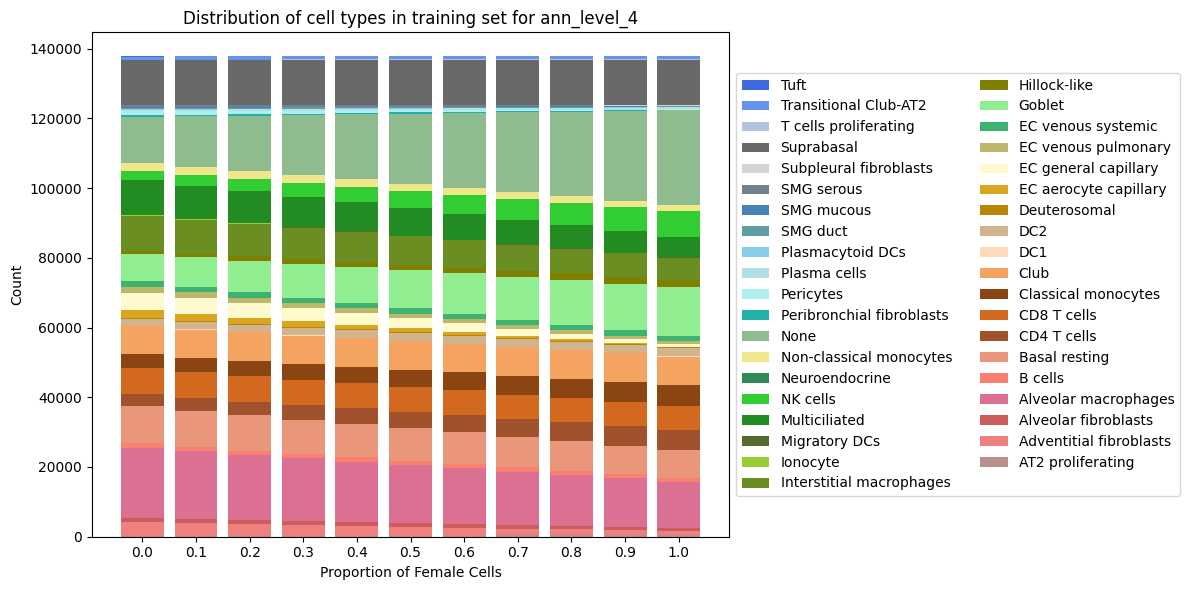

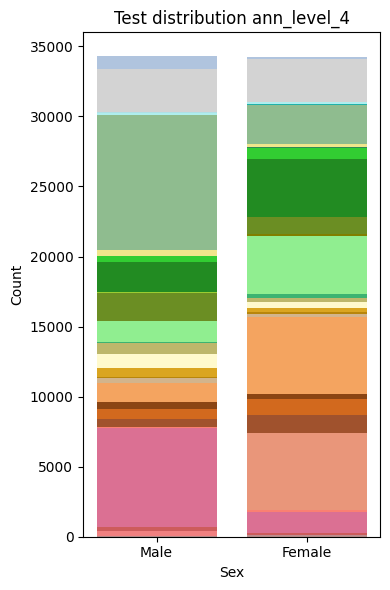

In [13]:
i = 'ann_level_4'
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
individual_labels = adata.obs['donor_id']
cell_type_labels = adata.obs[i].astype(str)
classes = sorted(set(cell_type_labels), reverse = True)
label_lists = []
sex_label_lists = []
maletest_lists = []
femaletest_lists = []

for prop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print(i, prop)
    X_selected, y_selected, train_sex, overlap, y_female_test, y_male_test = modif_train_clf_and_predict(embedding, cell_type_labels, sex_labels, individual_labels, prop, 'Suprabasal')
    label_lists.append(y_selected)
    sex_label_lists.append(train_sex)
    maletest_lists.append(y_male_test)
    femaletest_lists.append(y_female_test)
    print(f'Donor overlap: {len(overlap)}')

if i == 'ann_finest_level':
    d = plot_distribution(label_lists, sex_label_lists, f"Distribution of cell types in training set for {i}", list(color_mappings["ann_finest"].values()))
    t = plot_grouped_distribution(maletest_lists[0], femaletest_lists[0], f"Test distribution {i}", list(color_mappings["ann_finest"].values()))
else:
    d = plot_distribution(label_lists, sex_label_lists, f"Distribution of cell types in training set for {i}", list(color_mappings[f"ann_{i[-1]}"].values()))
    t = plot_grouped_distribution(maletest_lists[0], femaletest_lists[0], f"Test distribution {i}", list(color_mappings[f"ann_{i[-1]}"].values()))

Check that proportions of Suprabasal are fixed:

In [14]:
# in training set
print('Suprabasal check:')
for key in d.keys():
    total = sum(d[key]['Suprabasal'])
    print(total)
    print(round(d[key]['Suprabasal'][1]/total, 3))

Suprabasal check:
12881
0.0
12881
0.1
12881
0.2
12881
0.3
12881
0.4
12881
0.5
12881
0.6
12881
0.7
12881
0.8
12881
0.9
12881
1.0


In [15]:
# in test set
print(t['Suprabasal'])

[3053, 3053]


Check that sex proportions are still as they should be:

In [16]:
for i in range(len(sex_label_lists)):
    print(round(sum(sex_label_lists[i] == 'female')/len(sex_label_lists[i]),3))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


Export:

In [17]:
proportions = {}
proportions["training_sets"] = {"ann_4": {proportion: {'Suprabasal': values['Suprabasal']} for proportion, values in d.items()}}
proportions["male_test_set"] = {"ann_4": {"Suprabasal": t["Suprabasal"][0]}}
proportions["female_test_set"] = {"ann_4": {"Suprabasal": t["Suprabasal"][1]}}

#### Check for Monocyte-derived Mph:

ann_finest_level 0
Donor overlap: 0
ann_finest_level 0.1
Donor overlap: 0
ann_finest_level 0.2
Donor overlap: 0
ann_finest_level 0.3
Donor overlap: 0
ann_finest_level 0.4
Donor overlap: 0
ann_finest_level 0.5
Donor overlap: 0
ann_finest_level 0.6
Donor overlap: 0
ann_finest_level 0.7
Donor overlap: 0
ann_finest_level 0.8
Donor overlap: 0
ann_finest_level 0.9
Donor overlap: 0
ann_finest_level 1
Donor overlap: 0


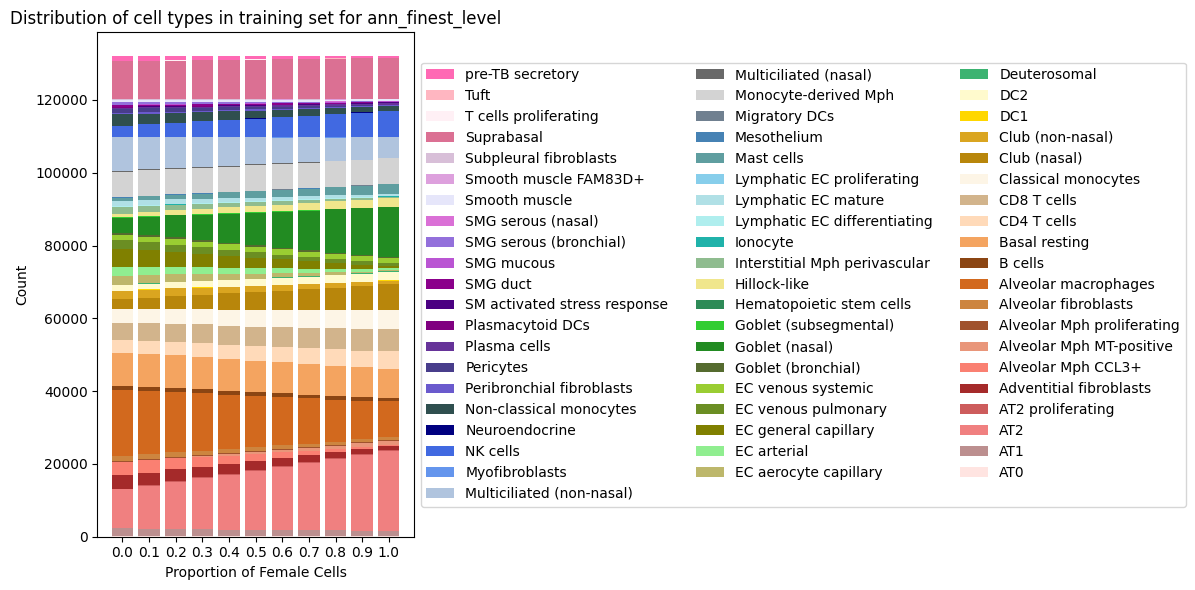

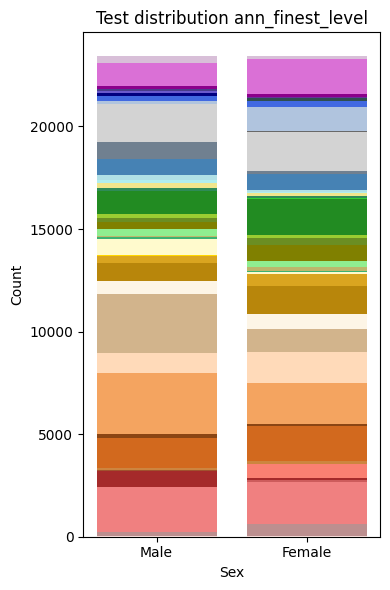

In [18]:
i = 'ann_finest_level'
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
individual_labels = adata.obs['donor_id']
cell_type_labels = adata.obs[i].astype(str)
classes = sorted(set(cell_type_labels), reverse = True)
label_lists = []
sex_label_lists = []
maletest_lists = []
femaletest_lists = []

for prop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print(i, prop)
    X_selected, y_selected, train_sex, overlap, y_female_test, y_male_test = modif_train_clf_and_predict(embedding, cell_type_labels, sex_labels, individual_labels, prop, 'Monocyte-derived Mph')
    label_lists.append(y_selected)
    sex_label_lists.append(train_sex)
    maletest_lists.append(y_male_test)
    femaletest_lists.append(y_female_test)
    print(f'Donor overlap: {len(overlap)}')

if i == 'ann_finest_level':
    d = plot_distribution(label_lists, sex_label_lists, f"Distribution of cell types in training set for {i}", list(color_mappings["ann_finest"].values()))
    t = plot_grouped_distribution(maletest_lists[0], femaletest_lists[0], f"Test distribution {i}", list(color_mappings["ann_finest"].values()))
else:
    d = plot_distribution(label_lists, sex_label_lists, f"Distribution of cell types in training set for {i}", list(color_mappings[f"ann_{i[-1]}"].values()))
    t = plot_grouped_distribution(maletest_lists[0], femaletest_lists[0], f"Test distribution {i}", list(color_mappings[f"ann_{i[-1]}"].values()))

Check that proportions of Mph are fixed:

In [19]:
# in training set
for key in d.keys():
    total = sum(d[key]['Monocyte-derived Mph'])
    print(total)
    print(round(d[key]['Monocyte-derived Mph'][1]/total, 3))

6930
0.0
6930
0.1
6930
0.2
6930
0.3
6930
0.4
6930
0.5
6930
0.6
6930
0.7
6930
0.8
6930
0.9
6930
1.0


In [20]:
# in test set
print(t['Monocyte-derived Mph'])

[781, 781]


Check that sex proportions are still as they should be:

In [21]:
for i in range(len(sex_label_lists)):
    print(round(sum(sex_label_lists[i] == 'female')/len(sex_label_lists[i]),3))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


Export:

In [22]:
proportions["training_sets"]["ann_finest"] = {proportion: {'Monocyte-derived Mph': values['Monocyte-derived Mph']} for proportion, values in d.items()}
proportions["male_test_set"]["ann_finest"] = {"Monocyte-derived Mph": t["Monocyte-derived Mph"][0]}
proportions["female_test_set"]["ann_finest"] = {"Monocyte-derived Mph": t["Monocyte-derived Mph"][1]}

## Result analysis


Here, we use the result files obtained after running scripts on the cluster.

In [23]:
general_path = 'donorbased_fix_classif'

training_counts_dict = proportions["training_sets"]
male_test_counts_dict = proportions["male_test_set"]
female_test_counts_dict = proportions["female_test_set"]

results_df = pd.DataFrame(columns=['Cell type', 'Slope test', 'Flip test'])

In [24]:
def det_ann_level(cell_type, cell_names):
    if cell_type in cell_names["ann_4"]:
        ann_level = "ann_4"
    else:
        ann_level = "ann_finest"
    return ann_level

# modify this to not take seed, classifier as input
def gather_cms(general_path, ann_level, cell_names, cell_type):    
    male_lst = []
    female_lst = []
    
    text_proportions = ['0', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1']
    for p in text_proportions:
        male_file_path = f'{general_path}/{ann_level}/{p}_male_metrics.pickle'
        female_file_path = f'{general_path}/{ann_level}/{p}_female_metrics.pickle'
    
        with open(male_file_path, 'rb') as file:
            male_results = pickle.load(file)
        with open(female_file_path, 'rb') as file:
            female_results = pickle.load(file)
    
        male_lst.append(pd.DataFrame(male_results['normalized_aggregated_confusion_matrix'], columns=cell_names[ann_level], index=cell_names[ann_level]))
        female_lst.append(pd.DataFrame(female_results['normalized_aggregated_confusion_matrix'], columns=cell_names[ann_level], index=cell_names[ann_level]))

    return male_lst, female_lst

def compute_difference(arr1, arr2):
    max_diff = float('-inf')
    
    for i in range(len(arr1)):
        diff = abs(arr1[i] - arr2[i])
        if diff > max_diff:
            max_diff = diff
    return max_diff

In [25]:
def plot_combined_classif(cell_type, classified, female_lst, male_lst, cell_counts_dict):
    proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], 
                          height_ratios=[2, 1], wspace=0.05, hspace = 0.3)

    ax1 = fig.add_subplot(gs[0, 0])  # line plot
    ax2 = fig.add_subplot(gs[1, 0])  # heatmap
    cax = fig.add_subplot(gs[1, 1])  # colorbar

    ###  line plot (classification trend)
    female_performance = [female_lst[prop].loc[cell_type, classified] for prop in range(len(proportions))]
    male_performance   = [male_lst[prop].loc[cell_type, classified] for prop in range(len(proportions))]

    max_diff = compute_difference(female_performance, male_performance)

    ax1.plot(proportions, female_performance, color='brown', label='Female test set', lw=2.5)
    ax1.plot(proportions, male_performance, color='darkblue', label='Male test set', lw=2.5)
    ax1.set_ylabel('% correctly classified cells', fontsize=15)
    # ax1.set_xlabel('% of female cells in training set', fontsize=15)
    ax1.legend(fontsize=15)
    ax1.grid(ls='--')

    yticks = ax1.get_yticks()
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([f"{y:.2f}" for y in yticks], fontsize=12)
    ax1.set_ylim(max(ax1.get_ylim()[0], 0), min(ax1.get_ylim()[1], 1.01))
    ax1.set_xticks(proportions)
    ax1.set_xticklabels(proportions, fontsize = 12)
    # ax1.set_xticklabels([])
    ax1.set_title(f'{cell_type} (Donor-based setting + Manual balancing)', fontsize=18)

    ### heatmap (training counts)
    data = []
    for prop in proportions:
        counts = cell_counts_dict[f"prop_{prop}"].get(cell_type, (0, 0))
        total = counts[0] + counts[1]
        data.append([total, counts[0], counts[1]])

    heatmap_data = np.array(data).T

    # modified color map because full one looks bad with black text
    cmap = plt.get_cmap('YlOrBr', 256)  
    new_cmap = cmap(np.linspace(0, 0.85, 256))  # avoid darkest green
    
    y_edges = np.arange(4)-0.5
    y_centers = np.arange(3)
    x_centers = np.array(proportions)
    dx = (x_centers[1] - x_centers[0]) / 2
    x_edges = np.concatenate([[x_centers[0]-dx], (x_centers[:-1]+x_centers[1:])/2, [x_centers[-1]+dx]])

    
    mesh = ax2.pcolormesh(
        x_edges, y_edges,
        heatmap_data,
        cmap=plt.cm.colors.ListedColormap(new_cmap),
        edgecolors='w', linewidth=0.5
    )
    ax2.set_ylim(2.5, -0.5)

    for i, y in enumerate(y_centers):
        for j, x in enumerate(x_centers):
            ax2.text(x, y, str(heatmap_data[i, j]), va='center', ha='center', fontsize=10)

    ax2.set_xticks(x_centers)
    ax2.set_xticklabels(proportions, fontsize=12)
    ax2.set_yticks(np.arange(3))
    ax2.set_yticklabels(['Total', 'Male', 'Female'], fontsize=15)
    ax2.set_xlabel('% of female cells in training set', fontsize=15)
    # ax2.set_title(f'Training Set Counts', fontsize=14)

    cbar = fig.colorbar(mesh, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.set_title("Training\n cell counts", fontsize=12)

    
    # make x-limits exactly match ax1
    ax2.set_xlim(ax1.get_xlim())
    plt.show()


    ### save performance trend:
    slope_female = check_slope(female_performance, proportions)
    slope_male = check_slope(male_performance, proportions)
    flip = (female_performance[0] - male_performance[0])*(female_performance[-1] - male_performance[-1])
        # if flip < 0: a flip has occured
        # if flip > 0: female performance is better/worse than the male performance at both ends of the spectrum
    if slope_female and slope_male:
        prod = slope_female * slope_male < 0
    else:
        prod = None
    return (slope_female, slope_male), (prod, flip < 0), max_diff

In [26]:
def check_slope(performance_values, proportions):
    try:
        model = LinearRegression().fit(np.reshape(proportions, (-1, 1)), np.reshape(performance_values, (-1, 1)))
        slope = model.coef_[0][0]
        return slope
    except ValueError as e:
        if "Input y contains NaN" in str(e):
            print(f"This cell type ({cell_type}) contains NaN values in a test set. Skipping slope calculation.")
        return None

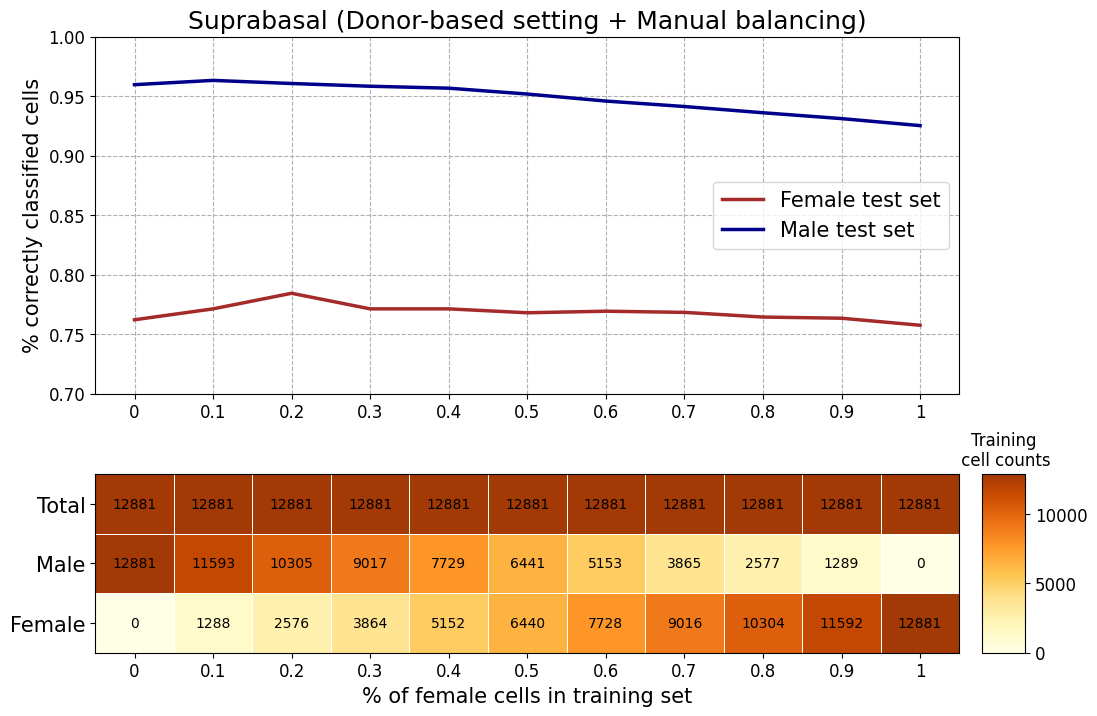

Suprabasal count in male test set: 3053
Suprabasal count in female test set: 3053


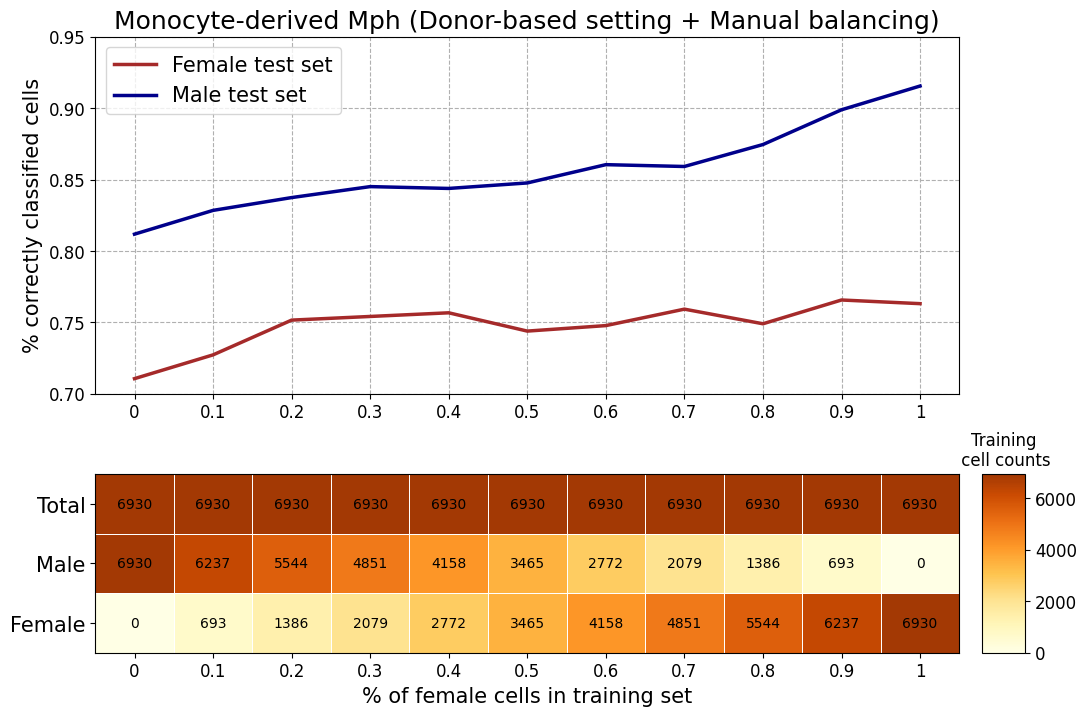

Monocyte-derived Mph count in male test set: 781
Monocyte-derived Mph count in female test set: 781


In [27]:
for cell_type in ['Suprabasal', 'Monocyte-derived Mph']:
    ann_level = det_ann_level(cell_type, cell_names)
    male_lst, female_lst = gather_cms(general_path, ann_level, cell_names, cell_type)
    slopes, opposing_tuple, max_diff = plot_combined_classif(cell_type, cell_type, female_lst, male_lst, training_counts_dict[ann_level])

    if cell_type in male_test_counts_dict[ann_level]:
        male_count = male_test_counts_dict[ann_level][cell_type]
    else:
        male_count = 0
    print(f'{cell_type} count in male test set: {male_count}')
    if cell_type in female_test_counts_dict[ann_level]:
        female_count = female_test_counts_dict[ann_level][cell_type]
    else:
        female_count = 0
    print(f'{cell_type} count in female test set: {female_count}')

    temp_df = pd.DataFrame({
        'Cell type': [cell_type],
        'Slope test': [opposing_tuple[0]],
        'Flip test': [opposing_tuple[1]],
        'Maximum performance difference': [max_diff],
        'Slope on female set': slopes[0],
        'Slope on male set': slopes[1]
    })
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

In [28]:
# consider 'distinct behavior' if both slope test and flip test are fulfilled:
results_df['Classification trend'] = results_df.apply(
    lambda row: 'Distinct' if row['Slope test'] and row['Flip test'] else 'Non-distinct',
    axis=1
)
results_df

,Cell type,Slope test,Flip test,Maximum performance difference,Slope on female set,Slope on male set,Classification trend
0,Suprabasal,False,False,0.197511,-0.011107,-0.038085,Non-distinct
1,Monocyte-derived Mph,False,False,0.152369,0.037248,0.086951,Non-distinct


In [29]:
print(f'{len(results_df[results_df["Classification trend"] == "Distinct"])} cell types with distinct behavior.')
print(f'{len(results_df[results_df["Classification trend"] == "Non-distinct"])} cell types with non-distinct behavior.')
print(f'{len(results_df[results_df["Classification trend"] == "Inconclusive"])} cell types with inconclusive behavior.')

0 cell types with distinct behavior.
2 cell types with non-distinct behavior.
0 cell types with inconclusive behavior.
